<a href="https://colab.research.google.com/github/hoangha30/VEngy_RAG/blob/main/Vintern_1B_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install timm einops
!wget file:///Users/hanguyen/Desktop/Screenshot%202025-10-15%20at%2011.00.26.png
!pip install --no-dependencies --upgrade flash_attn-2.6.3+cu123torch2.4cxx11abiFALSE-cp310-cp310-linux_x86_64.whl

file:///Users/hanguyen/Desktop/Screenshot%202025-10-15%20at%2011.00.26.png: Unsupported scheme ‘file’.
ERROR: flash_attn-2.6.3+cu123torch2.4cxx11abiFALSE-cp310-cp310-linux_x86_64.whl is not a supported wheel on this platform.


In [7]:
pip install transformers==4.37.2

In [13]:
import os
import numpy as np
import torch
import torchvision.transforms as T
# from decord import VideoReader, cpu
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            # Prioritize ratios that result in a larger area covered
            if ratio[0] * ratio[1] > best_ratio[0] * best_ratio[1]:
                 best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # Calculate the number of blocks needed to cover the image
    # Ensure all parts of the image are covered
    num_blocks_x = max(1, orig_width // image_size)
    num_blocks_y = max(1, orig_height // image_size)
    total_blocks = num_blocks_x * num_blocks_y

    # If the calculated total_blocks exceeds max_num, we might still have an issue,
    # but for now, let's try to process all calculated blocks.
    # A more sophisticated approach might involve resizing the image differently
    # or processing blocks in smaller batches if the model has input limits.

    # resize the image to be a multiple of image_size
    target_width = num_blocks_x * image_size
    target_height = num_blocks_y * image_size
    resized_img = image.resize((target_width, target_height))

    processed_images = []
    for i in range(total_blocks):
        box = (
            (i % num_blocks_x) * image_size,
            (i // num_blocks_x) * image_size,
            ((i % num_blocks_x) + 1) * image_size,
            ((i // num_blocks_x) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)

    # The assertion below might fail if total_blocks exceeds max_num and we still want to limit
    # assert len(processed_images) == blocks
    # Let's keep the thumbnail logic for now, though its usefulness with many blocks is questionable
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)

    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    # Pass the max_num to dynamic_preprocess if it's still relevant for downstream processing
    # or remove it if we aim to process all blocks. For now, let's process all blocks
    # and see if the model can handle the larger input tensor.
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [3]:
model_name = "5CD-AI/Vintern-3B-R-beta"
# model_name = "5CD-AI/Vintern-1B-v3_5"

In [4]:
try:
  model = AutoModel.from_pretrained(
      model_name,
      torch_dtype=torch.bfloat16,
      low_cpu_mem_usage=True,
      trust_remote_code=True,
      use_flash_attn=False,
  ).eval().cuda()
except:
  model = AutoModel.from_pretrained(
      model_name,
      torch_dtype=torch.bfloat16,
      low_cpu_mem_usage=True,
      trust_remote_code=True
  ).eval().cuda()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_internvl_chat.py: 0.00B [00:00, ?B/s]

configuration_intern_vit.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-3B-R-beta:
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-3B-R-beta:
- configuration_internvl_chat.py
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_internvl_chat.py: 0.00B [00:00, ?B/s]

modeling_intern_vit.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-3B-R-beta:
- modeling_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


conversation.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-3B-R-beta:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-3B-R-beta:
- modeling_internvl_chat.py
- modeling_intern_vit.py
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated

FlashAttention2 is not installed.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.43G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
!wget https://quynhontourist.com/wp-content/uploads/2021/03/ho-so-nang-luc-quy-nhon-tourist-quynhontourist-1.jpg

--2025-10-15 08:52:24--  https://quynhontourist.com/wp-content/uploads/2021/03/ho-so-nang-luc-quy-nhon-tourist-quynhontourist-1.jpg
Resolving quynhontourist.com (quynhontourist.com)... 103.221.223.46
Connecting to quynhontourist.com (quynhontourist.com)|103.221.223.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166523 (163K) [image/jpeg]
Saving to: ‘ho-so-nang-luc-quy-nhon-tourist-quynhontourist-1.jpg’

ho-so-nang-luc-quy- 100%[===================>] 162.62K   288KB/s    in 0.6s    

2025-10-15 08:52:25 (288 KB/s) - ‘ho-so-nang-luc-quy-nhon-tourist-quynhontourist-1.jpg’ saved [166523/166523]



In [5]:
import matplotlib.pyplot as plt
import glob

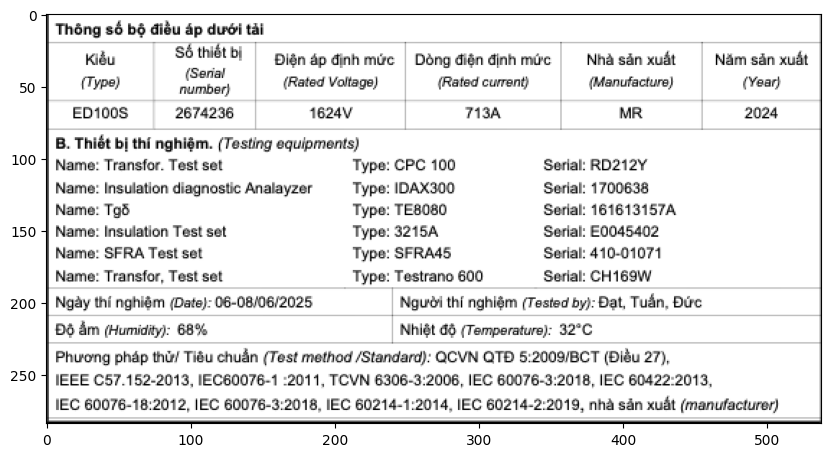

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Mô tả hình ảnh một cách chi tiết tất cả nội dung từ text đến các bảng, trả về dạng markdown.
Assistant: # Thông số bộ điều áp và kết quả thử nghiệm

**I. Thông số bộ điều áp:**

| Kiểu (Type) | Số thiết bị (Serial number) | Điện áp định mức (Rated Voltage) | Dòng điện định mức (Rated current) | Nhà sản xuất (Manufacturer) | Năm sản xuất (Year) |
|---|---|---|---|---|---| 
| ED10S | 26784326 | 1624V | 713A | MR | 2024 |

**II. Thiết bị thí nghiệm:**

| Tên thiết bị | Loại | Type | Serial number |
|---|---|---|---| 
| Transistor Test set | Insulation diagnostic Analyzer | IDAX300 | RD212X |
| Gõ | | TE8080 | 1700638 |
| Insulation Test set | | 321A | 161613157A |
| SFRA Test set | | SFRA45 | 410-01071 |
| Transistor Test set | | Testrono 600 | CH169W |

**III. Kết quả thử nghiệm:**

* **Ngày thử nghiệm:** 06/08/2025
* **Người thử nghiệm:** Đạt, Tuấn, Đức
* **Độ ẩm (Humidity):** 68%
* **Nhiệt độ (Temperature):** 32°C
* **Phương pháp thử/thuật tiêu chuẩn (Test method/Standard

In [17]:
test_image = "/content/Screenshot 2025-10-16 at 14.33.45.png"
plt.figure(figsize=(10,10))
plt.imshow(Image.open(test_image))
plt.show()
pixel_values = load_image(test_image, max_num=6).to(torch.bfloat16).cuda()
generation_config = dict(max_new_tokens= 512, do_sample=False, num_beams = 3, repetition_penalty=3.5)

question = '<image>\nMô tả hình ảnh một cách chi tiết tất cả nội dung từ text đến các bảng, trả về dạng markdown.'

response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')

In [16]:
response

'# Biên bản thí nghiệm máy biến áp\n\n**Thông tin chung:**\n\n* **Công trình/Dự án:** Trạm Biến Áp 220kV Vạn Ninh và đường dây đấu nối\n* **Vị trí/Ngăn lộ:** MBA AT1\n* **Mục đích:** Thí nghiệm sau lắp đặt\n* **Công ty:** Công ty CP Thương mại và Kỹ thuật Năng lượng Việt Nam\n* **Địa chỉ:** Tầng 3, tòa nhà Vinh Quang, khu Tây Nam Linh Đàm, phường Hoàng Liệt, Q. Hoàng Mai.\n* **Điện thoại:** 024.22492222 / 024.2210199\n* **Fax:** 024.36416501\n* **Website:** www.vengy.vn\n* **Năm sản xuất:** 2024\n* **Kiểu máy biến áp:** Ba pha, tự ngẫu, ngâm trong dầu, làm việc ngoài trời, làm mát ONAN/ONAF/OFAF\n* **Số chế tạo:** 244839-203\n* **Nhà sản xuất:** EEMC\n* **Công suất định mức:** 250/250/50 MVA\n* **Tỉ số biến:** 225+8x1,25%/115/23 kV\n* **Tổ đầu dây:** Yna0d11\n\n**Thông số máy biến áp:**\n\n| Điện áp ngắn mạch (%) | Uk (225-115) | Uk (225-23) | Uk (115-23) |\n|---|---|---|---|\n| 11,14% | 33,84% | 20,80% |\n\n**Thông số sứ xuyên đầu cực:**\n\n| Pha | Kiểu | Số thiết bị (Serial number) |